In [1]:
%cd ~/VerifyNN/ICNN_verification

/home/philipp/VerifyNN/ICNN_verification


/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import onnx
from onnx2pytorch import ConvertModel
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple
from collections import OrderedDict

# Import the Feedforward-NN
It has to bee a SequentialNN

In [4]:

"""nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device(device)), strict=False)"""


"""
nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)
"""


"""nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device("cpu")), strict=False)"""



'nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])\nnn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device("cpu")), strict=False)'

#### or make onnx to Sequential

In [5]:
onnx_model = onnx.load("script/Experiments/mnist-net_256x4.onnx")
pytorch_model = ConvertModel(onnx_model)

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
state_dict = pytorch_model.state_dict()
my_state_dict = {}
for i, key in enumerate(state_dict):
    actual_index = i * 2
    my_state_dict[f"{actual_index}.bias"] = state_dict[f"_initializer_layers_{actual_index}_bias"]
    my_state_dict[f"{actual_index}.weight"] = state_dict[f"_initializer_layers_{actual_index}_weight"]
    if actual_index == 8:
        break
    
nn.load_state_dict(my_state_dict)

/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/onnx2pytorch/convert/layer.py:29: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699115971163/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


<All keys matched successfully>

In [6]:
parameter_list = list(nn.parameters())
output_size = 10
number_layer = (len(parameter_list) - 2) // 2

# Load the data to apply the verification process for

In [7]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [8]:
transform = Compose([ToTensor()])
training_data = MNIST(root="./mnist", train=True, download=True, transform=transform)

# Settings for the optimization 

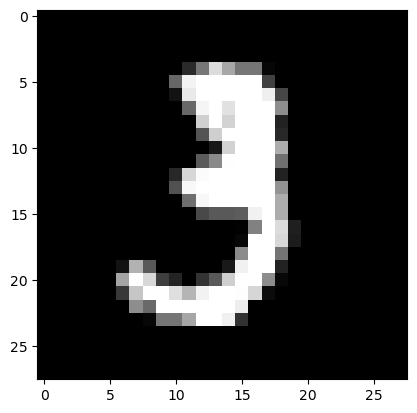

The label is 3
NN classifies image correctly as 3


In [9]:
# image to do the verification for
image_index = 10

# epsilon radius
eps = 0.03

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")


In [10]:
total_correct = 0
total_wrong = 0
do_test = False
if do_test:
    for image, label in training_data:
        torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
        if torch.argmax(nn(torch_image)).item() == label:
            total_correct += 1
        else:
            total_wrong += 1
            
        print(total_correct, total_wrong)
    print(f"accuracy {total_correct/ len(training_data)}")


# Add the objective to the optimization problem
in this case we want to find the maximum difference between any one neuron and the target neuron (label)

In [11]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    """
    
    :param model: the optimization problem in gurobi encoding the NN
    :param nn_layer_out_bounds: torch.Tensor, approximating the upper and lower bounding the output layer of the NN
    :param label: index of the label or target neuron which is compared against
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :param sovler_bound: provides a bound for the gurobi solver. If this bound is achieved, the optimizer stops
    """
    
    out_lb = nn_layer_out_bounds[-1][0].detach().cpu().numpy()
    out_ub = nn_layer_out_bounds[-1][1].detach().cpu().numpy()
    
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    
    difference_lb.pop(label)
    difference_ub.pop(label)
    
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)
    
    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    if sovler_bound != None:
        model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)

# Get the output variables by name 
given the gurobi model, the output size of the NN and the index of output layer

In [12]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [13]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

# Defining function to call Gurobi optimizer

In [14]:
def optimize_model(model, output_vars):
    """
    
    :param model: the optimization problem in gurobi encoding the NN and the objective 
    :param output_vars: the gurobi variables from the model of the NN describing the output neurons of the NN
    :return True if verification was successful, else false 
    """
    
    start = time.time()
    model.update()
    model.optimize()
    
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

# Calculate box-bounds to provide a rough approximation of NN

In [15]:
input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0].tolist())
print(simple_bounds_affine_out[-1][1].tolist())


[-1032.5534949464775, -872.925756570502, -1141.959246872821, -1203.2976582067317, -1105.71108391385, -986.7314910178, -954.3195523478023, -1036.1493852084127, -1236.67322175955, -945.4201504345255]
[822.8642229269997, 734.7687204634507, 739.7653141953176, 644.5772098039621, 858.509191346222, 782.4145591124341, 917.3556478411417, 876.5302067990468, 868.9227335602427, 935.6565249544532]


# Do Single-Neuron-Verification

In [16]:
use_snv = False
if use_snv:
    t = time.time()
    
    # define the Verifier
    snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)
    
    # generate the constraints
    snv_verifier.generate_constraints_for_net()
    snv_model = snv_verifier.model
    snv_model.update()
    
    # add the objective to the gurobi model
    snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
    add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars, sovler_bound=None)
    print("constraint generation time: {}".format(time.time() - t))
    
    print("start with optimization")
    optimize_model(snv_model, snv_out_vars)

 # Do MILP-Verification if wanted

In [16]:
if use_milp:
    # define the Verifier
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    
    # generate the constraints
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    
    # add the objective to the gurobi model
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

# get bounds with crown

In [17]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model)
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [18]:
def load_vnnlib_spec(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=torch.float32).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=torch.float32).reshape(input_shape)
    center = 0.5*(data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)
    
    return x

In [19]:
onnx_path = 'script/Experiments/mnist-net_256x4.onnx'
vnnlib_path = 'script/Experiments/prop_0_0.03.vnnlib'

In [20]:
model = load_onnx_model(onnx_path, [1,1,1,784])
x = load_vnnlib_spec(vnnlib_path, [1,1,1,784], 10)

/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/onnx2pytorch/convert/model.py:167: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not self.experimental and inputs[0].shape[self.batch_dim] > 1:
/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/auto_LiRPA/parse_graph.py:154: FutureWarning: 'torch.onnx.symbolic_helper._set_opset_version' is deprecated in version 1.13 and will be removed in 2.0. Please remove its usage and avoid setting internal variables directly.
  _set_opset_version(12)
/home/philipp/anaconda3/envs/icnn-crown/lib/python3.11/site-packages/vnnlib/compat.py:283: UserWarning: literal negation does not strictly follow SMT-LIB
  ast_node = parse_file(vnnlib_filename, strict=False)


In [21]:
def get_layers(model):
    return [l for l in model.nodes() if l.perturbed]

In [22]:
def get_intermediate_bounds(model):
    """
    Returns a dictionary containing the concrete lower and upper bounds of each layer.
    
    Implemented own method to filter out bounds for weight matrices.
    
    Only call this method after compute_bounds()!
    """
    od = OrderedDict()
    for l in get_layers(model):
        if hasattr(l, 'lower'):
            od[l.name] = (l.lower, l.upper)
            
    return od

In [23]:
model.compute_bounds(x=(x,), method='ibp')
model.compute_bounds(x=(x,), method='crown')

(tensor([[-16.1574, -13.2932, -17.4020, -26.5492, -17.5962, -16.9601, -15.3861,
          -17.6454, -20.9628, -15.7071]], grad_fn=<ViewBackward0>),
 tensor([[13.8042, 12.8868, 11.2402,  7.7739, 14.1580, 12.1219, 15.4775, 13.8467,
          12.8768, 15.7155]], grad_fn=<ViewBackward0>))

In [24]:
bounds_dict_crown = get_intermediate_bounds(model)

In [25]:
bounds_dict_crown.keys()
crown_bounds_affine_out = []
for i, key in enumerate(bounds_dict_crown.keys()):
    print(key)
    if i == 0: # use this if ibp is used (or i % 2 == 1:)
        continue
    lb, ub = bounds_dict_crown[key]
    crown_bounds_affine_out.append([lb.type(data_type).view(-1).to(device), ub.type(data_type).view(-1).to(device)])



/0
/input
/input.3
/input.7
/input.11
/30


In [26]:
crown_bounds_layer_out = []
relu = torch.nn.ReLU()
for i, (lb, ub) in enumerate(crown_bounds_affine_out):
    if i == len(crown_bounds_affine_out) - 1:
        crown_bounds_layer_out.append([lb, ub])
    else:
        lb_layer = relu(lb)
        ub_layer = relu(ub)
        crown_bounds_layer_out.append([lb_layer, ub_layer])

In [27]:
print(crown_bounds_affine_out[-1][0])

tensor([-16.1574, -13.2932, -17.4020, -26.5492, -17.5962, -16.9601, -15.3861,
        -17.6454, -20.9628, -15.7071], dtype=torch.float64,
       grad_fn=<ViewBackward0>)


In [29]:
for (lb_crown, ub_crown), (lb_simple, ub_simple) in zip(crown_bounds_affine_out, simple_bounds_affine_out):
    print(torch.isclose(lb_crown, lb_simple).all())
    print(torch.isclose(ub_crown, ub_simple).all())
    print("===============")

tensor(True)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


# Attempt verification using DHOV
See MultiDHOV.py and ICNNFactory.py for detailed documentation about the parameters

In [30]:
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
from script.DHOV.Sampling.PerGroupSamplingStrategy import PerGroupSamplingStrategy
from script.DHOV.Sampling.ZonotopeSamplingStrategy import ZonotopeSamplingStrategy

center = torch.flatten(torch_image)
#sampling_strategy = PerGroupLineSearchSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=10000)
sampling_strategy = ZonotopeSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=10000)
# number of neurons which are in one group
group_size = 20

# method of sampling data points
#sampling_method = "per_group_sampling"

# Size of each layer of the ICNN except for the input layer. (given by group size)
net_size = [5, 1]

# picking the typ of ICNN to use
#icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)

bounds_affine_out_snr, bounds_layer_out_snr = crown_bounds_affine_out, crown_bounds_layer_out

overall_time = time.time()
dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                 init_affine_bounds=bounds_affine_out_snr, init_layer_bounds=bounds_layer_out_snr,
                                 icnn_batch_size=10000, use_over_approximation=True, break_after=None,
                                 tighten_bounds=False, 
                                 use_fixed_neurons_in_grouping=False, layers_as_snr=[], layers_as_milp=[3],
                                 force_inclusion_steps=3, preemptive_stop=True,
                                data_grad_descent_steps=0, opt_steps_gd=100,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False, print_last_loss=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included", sampling_strategy=sampling_strategy)
print("overall time: {}".format(time.time() - overall_time))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202


        time for sampling: 0.2711329460144043
    layer progress, group 1 of 3 


/home/philipp/VerifyNN/ICNN_verification/script/Optimizer/sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699115971163/work/torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 58.751030683517456
        actual verification time 3.9095919132232666
        time for verification: 4.059848070144653
    layer progress, group 2 of 3 
        time for training: 58.375272035598755
        actual verification time 1.9531643390655518
        time for verification: 2.0732223987579346
    layer progress, group 3 of 3 
        time for training: 55.79684400558472
        actual verification time 1.2640161514282227
        time for verification: 1.3391497135162354

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.26760101318359375
    layer progress, group 1 of 5 
        time for training: 57.909106731414795
        actual verification time 3.62912917137146
        time for verification: 3.72597336769104
    layer progress, group 2 of 5 
        time for training: 55.20630598068237
        actual verification time 2.0571393966674805
        time for verification: 2.1653263568878174
    la

# Getting an overview over what DHOV has done
show the neuron groups created by DHOV for each layer by index

In [48]:
for i, groups_in_layer in enumerate(dhov_verifier.all_group_indices):
    print(f"Layer {i}")
    for k, group in enumerate(groups_in_layer):
        print(f"    Group {k}: {group}")

Layer 0
    Group 0: [0, 1, 8, 10, 13, 15, 29, 30, 35, 42, 61, 62, 69, 75, 78, 80, 86, 92, 93, 97]
    Group 1: [114, 120, 127, 134, 137, 146, 156, 166, 172, 175, 176, 177, 178, 179, 182, 187, 188, 190, 194, 195]
    Group 2: [199, 200, 201, 204, 207, 213, 216, 219, 220, 229, 230, 235, 251, 255]
Layer 1
    Group 0: [2, 3, 5, 6, 7, 14, 17, 20, 21, 25, 33, 40, 42, 43, 44, 47, 49, 54, 63, 64]
    Group 1: [65, 67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 82, 83, 92, 93, 94, 95, 96, 100, 101]
    Group 2: [103, 110, 118, 121, 123, 126, 128, 131, 132, 134, 135, 136, 140, 141, 142, 143, 154, 156, 162, 165]
    Group 3: [166, 181, 186, 189, 190, 191, 193, 204, 205, 208, 212, 214, 215, 216, 217, 218, 219, 220, 223, 225]
    Group 4: [233, 234, 237, 239, 240, 241, 242, 243, 246, 248, 252, 254]
Layer 2
    Group 0: [27, 31, 38, 43, 44, 61, 107, 117, 118, 131, 133, 146, 151, 157, 161, 172, 186, 187, 200, 203]
    Group 1: [205, 211, 229, 243, 246]
Layer 3


show the output bounds for the NN. Hopefully these are better than the box-bounds and the bounds obtained by the Single-Neuron-Verification

In [32]:

print(dhov_verifier.bounds_affine_out[-1][0].tolist())
print(dhov_verifier.bounds_affine_out[-1][1].tolist())

[-16.157413482666016, -13.29317855834961, -17.402013778686523, -26.549163818359375, -17.596237182617188, -16.960063934326172, -15.386093139648438, -17.645418167114258, -20.962833404541016, -15.707077980041504]
[13.804231643676758, 12.88681411743164, 11.240225791931152, 7.7739362716674805, 14.157962799072266, 12.121850967407227, 15.4775390625, 13.846749305725098, 12.87679672241211, 15.715452194213867]


# Starting the optimization process

In [33]:
# make changes on a copy of the gurobi model generated by DHOV
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.Params.LogToConsole = 1
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

Set parameter LogToConsole to value 1


In [34]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars, sovler_bound=10)

Set parameter BestObjStop to value 10


In [35]:
overall_time = time.time()
optimize_model(dhov_model, dhov_out_vars)
print("overall time: {}".format(time.time() - overall_time))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3515 rows, 3388 columns and 406002 nonzeros
Model fingerprint: 0xf4b5be83
Model has 1 general constraint
Variable types: 3133 continuous, 255 integer (255 binary)
Coefficient statistics:
  Matrix range     [9e-08, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-04, 2e+03]
  RHS range        [3e-04, 3e+01]


Presolve removed 1676 rows and 1206 columns
Presolve time: 1.00s
Presolved: 1839 rows, 2182 columns, 132918 nonzeros
Variable types: 1985 continuous, 197 integer (197 binary)
Found heuristic solution: objective 0.0278264

Root relaxation: objective 4.021144e+01, 154 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.21144    0    8    0.02783   40.21144      -     -    1s
H    0     0                       0.0278264   40.21144      -     -    1s
     0     0   33.93493    0  152    0.02783   33.93493      -     -    1s
     0     0   18.15957    0  106    0.02783   18.15957      -     -    1s
     0     0    8.98195    0  100    0.02783    8.98195      -     -    2s
     0     0    8.52818    0  125    0.02783    8.52818      -     -    2s
     0     0    8.52818    0  120    0.02783    8.52818      -     -    2s
     0     0 

In [46]:
overall_time = time.time()
optimize_model(dhov_model, dhov_out_vars)
print("overall time: {}".format(time.time() - overall_time))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3515 rows, 3388 columns and 406040 nonzeros
Model fingerprint: 0x4ffc31b1
Model has 1 general constraint
Variable types: 3133 continuous, 255 integer (255 binary)
Coefficient statistics:
  Matrix range     [9e-08, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-04, 2e+03]
  RHS range        [3e-04, 3e+01]
Presolve removed 1680 rows and 1196 columns
Presolve time: 1.13s
Presolved: 1835 rows, 2192 columns, 132992 nonzeros
Variable types: 1997 continuous, 195 integer (195 binary)
Found heuristic solution: objective 0.0282443

Root relaxation: objective 4.175592e+01, 160 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

In [40]:
overall_time = time.time()
optimize_model(dhov_model, dhov_out_vars)
print("overall time: {}".format(time.time() - overall_time))

var 0: 0.16110945057845236
var 1: 0.01447281188668656
var 2: 0.04973589465005454
var 3: -0.09595817405165755
var 4: 0.1035169702281222
var 5: -0.17861045305250783
var 6: 0.1375025093491942
var 7: -0.030975243664906255
var 8: -0.030316054458492198
var 9: 1.1474069172917436
property NOT verified with max difference 1.2433650913434011
overall time: 244.71441507339478


# Sampling Experiments

In [57]:
def run_experiment(group_size=20, sample_count=10000, icnn_epochs=200, gurobi_timeout=300, tighten_bounds=False):
    center = torch.flatten(torch_image)
    #sampling_strategy = PerGroupLineSearchSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=sample_count)
    sampling_strategy = ZonotopeSamplingStrategy(center, eps, nn, keep_ambient_space=True, sample_new=False, sample_count=sample_count)
    # number of neurons which are in one group
    group_size = group_size

    # method of sampling data points
    #sampling_method = "per_group_sampling"

    # Size of each layer of the ICNN except for the input layer. (given by group size)
    net_size = [5, 1]

    # picking the typ of ICNN to use
    #icnn_factory = ICNNFactory("approx_max", net_size, maximum_function="SMU", function_parameter=0.3)
    icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)
    #icnn_factory = ICNNFactory("standard", net_size, adapt_layer_for_init=True)

    bounds_affine_out_snr, bounds_layer_out_snr = crown_bounds_affine_out, crown_bounds_layer_out

    overall_time = time.time()
    dhov_verifier = multidhov.MultiDHOV()
    dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=icnn_epochs,
                                    init_affine_bounds=bounds_affine_out_snr, init_layer_bounds=bounds_layer_out_snr,
                                    icnn_batch_size=10000, use_over_approximation=True, break_after=None,
                                    tighten_bounds=tighten_bounds, 
                                    use_fixed_neurons_in_grouping=False, layers_as_snr=[], layers_as_milp=[3],
                                    force_inclusion_steps=3, preemptive_stop=True,
                                    data_grad_descent_steps=0, opt_steps_gd=100,
                                    train_outer=False, print_training_loss=False, print_new_bounds=False,
                                    grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False, print_last_loss=False,
                                    should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included", sampling_strategy=sampling_strategy)
    print("overall DHOV time: {}".format(time.time() - overall_time))


    dhov_model = dhov_verifier.nn_encoding_model.copy()
    dhov_model.Params.LogToConsole = 1
    dhov_model.Params.TimeLimit = gurobi_timeout
    dhov_model.update()
    dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

    add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars, sovler_bound=10)

    overall_time = time.time()
    optimize_model(dhov_model, dhov_out_vars)
    print("overall time: {}".format(time.time() - overall_time))

    return dhov_model

In [39]:
model_3_1000 = run_experiment(group_size=3, sample_count=1000)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.10282516479492188
    layer progress, group 1 of 18 


/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 8.601254940032959
        actual verification time 0.1498274803161621
        time for verification: 0.1864635944366455
    layer progress, group 2 of 18 
        time for training: 8.696409463882446
        actual verification time 0.03629732131958008
        time for verification: 0.0648190975189209
    layer progress, group 3 of 18 
        time for training: 8.503027439117432
        actual verification time 0.16184782981872559
        time for verification: 0.20577096939086914
    layer progress, group 4 of 18 
        time for training: 8.854987382888794
        actual verification time 0.1302790641784668
        time for verification: 0.16248536109924316
    layer progress, group 5 of 18 
        time for training: 7.193047285079956
        actual verification time 0.10971450805664062
        time for verification: 0.14309263229370117
    layer progress, group 6 of 18 
        time for training: 6.8958446979522705
        actual verification time 0.103

In [40]:
model_no_train = run_experiment(group_size=20, sample_count=2, icnn_epochs=0)


approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.01198267936706543
    layer progress, group 1 of 3 
        time for training: 0.0028676986694335938


/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "
/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        actual verification time 0.08408474922180176
        time for verification: 0.20911502838134766
    layer progress, group 2 of 3 
        time for training: 0.0024230480194091797
        actual verification time 0.14178037643432617
        time for verification: 0.23234248161315918
    layer progress, group 3 of 3 
        time for training: 0.0028543472290039062
        actual verification time 0.4531731605529785
        time for verification: 0.5212678909301758

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.006251335144042969
    layer progress, group 1 of 5 
        time for training: 0.002566099166870117
        actual verification time 1.06105375289917
        time for verification: 1.1657845973968506
    layer progress, group 2 of 5 
        time for training: 0.0018849372863769531
        actual verification time 1.3728246688842773
        time for verification: 1.4658193588256836
    layer progress, group 3 of 

In [41]:
model_standard = run_experiment(group_size=20, sample_count=1000)


approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.03199481964111328
    layer progress, group 1 of 3 
        time for training: 2.0752391815185547
        actual verification time 2.9479358196258545
        time for verification: 3.042663812637329
    layer progress, group 2 of 3 
        time for training: 2.5505759716033936
        actual verification time 2.4056692123413086
        time for verification: 2.5244216918945312
    layer progress, group 3 of 3 
        time for training: 1.7860713005065918
        actual verification time 1.255746603012085
        time for verification: 1.3289878368377686

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.023415803909301758
    layer progress, group 1 of 5 
        time for training: 1.8878052234649658
        actual verification time 3.9535865783691406
        time for verification: 4.04443097114563
    layer progress, group

In [47]:
model_group_30 = run_experiment(group_size=30, sample_count=1000)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.0208437442779541
    layer progress, group 1 of 2 


/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 2.5612213611602783
        actual verification time 46.196574449539185
        time for verification: 46.34085416793823
    layer progress, group 2 of 2 
        time for training: 2.870955467224121
        actual verification time 5.97473669052124
        time for verification: 6.116667747497559

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.0583035945892334
    layer progress, group 1 of 4 
        time for training: 3.501305103302002
        actual verification time 14.684276580810547
        time for verification: 14.86096739768982
    layer progress, group 2 of 4 
        time for training: 2.626063346862793
        actual verification time 7.574552774429321
        time for verification: 7.73034930229187
    layer progress, group 3 of 4 
        time for training: 2.8886122703552246
        actual verification time 14.89427661895752
        time for verification: 15.050851106643677
    layer pr

In [48]:
model_group_40 = run_experiment(group_size=40, sample_count=1000)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.02134561538696289
    layer progress, group 1 of 2 


/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 2.3945469856262207
        actual verification time 122.3186445236206
        time for verification: 122.48711514472961
    layer progress, group 2 of 2 
        time for training: 2.00925612449646
        actual verification time 1.0070769786834717
        time for verification: 1.087116003036499

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.018616914749145508
    layer progress, group 1 of 3 
        time for training: 2.5475637912750244
        actual verification time 7.393897294998169
        time for verification: 7.5643150806427
    layer progress, group 2 of 3 
        time for training: 2.6663620471954346
        actual verification time 47.55817890167236
        time for verification: 47.74350690841675
    layer progress, group 3 of 3 
        time for training: 3.303053855895996
        actual verification time 1.4959101676940918
        time for verification: 1.5620605945587158

approxim

In [52]:
model_group_50 = run_experiment(group_size=50, sample_count=1000)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.01941227912902832
    layer progress, group 1 of 2 


/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)


        time for training: 3.242128610610962
        actual verification time 522.4021325111389
        time for verification: 522.5989282131195
    layer progress, group 2 of 2 
        time for training: 6.898123025894165
        actual verification time 0.1260685920715332
        time for verification: 0.1606123447418213

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.01304769515991211
    layer progress, group 1 of 2 
        time for training: 2.630573034286499
        actual verification time 25.35100531578064
        time for verification: 25.53861117362976
    layer progress, group 2 of 2 
        time for training: 2.4566876888275146
        actual verification time 23.67660665512085
        time for verification: 23.839620351791382

approximation of layer: 2
    number of fixed neurons for current layer: 231
        time for sampling: 0.007760047912597656
    layer progress, group 1 of 1 
        time for training: 2.

In [49]:
model_goup_20_2000 = run_experiment(group_size=20, sample_count=2000)


approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.05321216583251953
    layer progress, group 1 of 3 
        time for training: 4.640896320343018
        actual verification time 3.559983730316162
        time for verification: 3.6488749980926514
    layer progress, group 2 of 3 
        time for training: 4.932296276092529
        actual verification time 2.743372678756714
        time for verification: 2.8291447162628174
    layer progress, group 3 of 3 
        time for training: 5.048974990844727
        actual verification time 1.5366032123565674
        time for verification: 1.6174836158752441

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.062166452407836914
    layer progress, group 1 of 5 
        time for training: 5.626727342605591
        actual verification time 2.750223159790039
        time for verification: 2.861220359802246
    layer progress, group 2 o

In [55]:
model_group_20_4 = run_experiment(group_size=20, sample_count=4)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "
/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.010039329528808594
    layer progress, group 1 of 3 
        time for training: 0.2241671085357666
        actual verification time 1.3830418586730957
        time for verification: 1.5163047313690186
    layer progress, group 2 of 3 
        time for training: 0.16515660285949707
        actual verification time 1.2884495258331299
        time for verification: 1.3947219848632812
    layer progress, group 3 of 3 
        time for training: 0.18889117240905762
        actual verification time 1.7691612243652344
        time for verification: 1.8620619773864746

approximation of layer: 1
    number of fixed neurons for current layer: 164
        time for sampling: 0.005259037017822266
    layer progress, group 1 of 5 
        time for training: 0.15434598922729492
        actual verification time 2.6799886226654053
        time for verification: 2.7857370376586914
    layer progres

In [58]:
model_group_20_4_tight = run_experiment(group_size=20, sample_count=4, tighten_bounds=True)

/home/philipp/VerifyNN/ICNN_verification/script/DHOV/MultiDHOV.py:188: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "
/home/philipp/VerifyNN/ICNN_verification/script/NeuralNets/Networks.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = b - torch.tensor(value, device=device)



approximation of layer: 0
    number of fixed neurons for current layer: 202
        time for sampling: 0.014950037002563477
    layer progress, group 1 of 3 
        time for training: 0.3247511386871338
        actual verification time 2.9122021198272705
        time for verification: 3.086798667907715
    layer progress, group 2 of 3 
        time for training: 0.16533541679382324
        actual verification time 0.8394138813018799
        time for verification: 0.9443075656890869
    layer progress, group 3 of 3 
        time for training: 0.17354321479797363
        actual verification time 1.056696891784668
        time for verification: 1.149209976196289

approximation of layer: 1
    time for icnn_bound calculation: 11.858925819396973
    number of fixed neurons for current layer: 175
        time for sampling: 0.007252931594848633
    layer progress, group 1 of 5 
        time for training: 0.25215649604797363
        actual verification time 5.360803842544556
        time fo

In [56]:
print("no train:     ", model_no_train.ObjBound)
print("train 4:      ", model_group_20_4.ObjBound)
print("small groups: ", model_3_1000.ObjBound)
print("standard:     ", model_standard.ObjBound)
print("standard + 2k:", model_goup_20_2000.ObjBound)
print("group 30:     ", model_group_30.ObjBound)
print("group 40:     ", model_group_40.ObjBound)
print("group 50:     ", model_group_50.ObjBound)

no train:      2.3454062234782436
train 4:       1.8356091595551955
small groups:  2.0271586307862233
standard:      1.1835184838145076
standard + 2k: 1.1978796014469548
group 30:      1.2226436903072544
group 40:      1.138981082375489
group 50:      1.1581171964803676
